In [1]:
#setup - rememeber to switch to tensorflow 2.3 kernel...
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io as sio
import datetime
import trimesh
import time

#need to have these two lines to work on my ancient 1060 3gb
#  https://stackoverflow.com/questions/43990046/tensorflow-blas-gemm-launch-failed
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

print(tf.__version__)

# %matplotlib inline
# plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
# plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'
%matplotlib notebook

%load_ext tensorboard

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2
%autosave 180

C:\Users\Derm\anaconda3\envs\tf23\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Derm\anaconda3\envs\tf23\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\Derm\anaconda3\envs\tf23\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


2.3.0


Autosaving every 180 seconds


In [71]:
#load OFF file from ModelNet10 dir
start = time.time()
# fn = 'C:/Users/Derm/Desktop/big/ModelNet10/toilet/train/toilet_0069.off'
# fn = 'C:/Users/Derm/Desktop/big/ModelNet10/sofa/train/sofa_0370.off'
fn = 'C:/Users/Derm/Desktop/big/ModelNet10/bed/train/bed_0320.off'


M = trimesh.load(fn)
test = trimesh.sample.sample_surface(M, 100)
print("took ", time.time() - start, "seconds")

took  0.014003753662109375 seconds


In [72]:
#use Vedo to plot OG and subsampled surfaces
from vedo import *
from ipyvtklink.viewer import ViewInteractiveWidget

plt1 = Plotter(N = 1, axes = 4, bg = (1, 1, 1), interactive = True)
disp = []

# disp.append(Points(M.vertices, c = 'blue', r = 4))
disp.append(Points(test[0], c = 'red', r = 5))
toilet = Mesh(M).c("gray").alpha(0.2)
disp.append(toilet)

plt1.show(disp, "surface sampling test")
ViewInteractiveWidget(plt1.window)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

In [4]:
#define rotation matrix used to transform point clouds
def R_tf(angs):
    if len(tf.shape(angs)) == 1:
        angs = angs[None,:]
    phi = angs[:,0]
    theta = angs[:,1]
    psi = angs[:,2]
    mat = tf.Variable([[cos(theta)*cos(psi), sin(psi)*cos(phi) + sin(phi)*sin(theta)*cos(psi), sin(phi)*sin(psi) - sin(theta)*cos(phi)*cos(psi)],
                       [-sin(psi)*cos(theta), cos(phi)*cos(psi) - sin(phi)*sin(theta)*sin(psi), sin(phi)*cos(psi) + sin(theta)*sin(psi)*cos(phi)],
                       [sin(theta), -sin(phi)*cos(theta), cos(phi)*cos(theta)]
                        ])
    mat = tf.transpose(mat, [2, 0, 1])
    mat = tf.squeeze(mat)
    return mat

# determine euler angles from rotation matrix
def R2Euler(mat):
    if len( tf.shape(mat) ) == 2:
        mat = mat[None, :, :]
    R_sum = np.sqrt(( mat[:,0,0]**2 + mat[:,0,1]**2 + mat[:,1,2]**2 + mat[:,2,2]**2 ) / 2)
    phi = np.arctan2(-mat[:,1,2],mat[:,2,2])
    theta = np.arctan2(mat[:,0,2], R_sum)
    psi = np.arctan2(-mat[:,0,1], mat[:,0,0])
    angs = np.array([phi, theta, psi])
    return angs

In [295]:
#generate toy dataset using all of the toilets in the ModelNet10 repository
numMeshes = 100 #344
ptsPerCloud = 256 #was 25 in OG method 
iterPerMesh = 100 #100  #number of times to sample clouds from each mesh

#init vector to store sampled point clouds
x = np.zeros([numMeshes*iterPerMesh, ptsPerCloud*2, 3])
#init vector to store transformations 
y = np.zeros([numMeshes*iterPerMesh, 6]) #rotation and translation
# y = np.zeros([numMeshes*iterPerMesh, 3]) #if only considering translations

#scale trans and rotation params so outputs are equally weighted
trans_scale = 10.0 #2.0
rot_scale = 0.2 #0.2

for i in range(numMeshes):
    if i % 10 == 0:
        print(i)
    fn = 'C:/Users/Derm/Desktop/big/ModelNet10/toilet/train/toilet_%04d.off' %(i+1) #loop through file names
#     fn = 'C:/Users/Derm/Desktop/big/ModelNet10/bed/train/bed_%04d.off' %(i+1) #loop through file names
#     'C:/Users/Derm/Desktop/big/ModelNet10/toilet/train/toilet_0069.off' #debug -> only use single toilet model
    M = trimesh.load(fn)

    #more efficient to sample all points at once and then just use some for each frame
    sam1 = trimesh.sample.sample_surface(M, iterPerMesh*ptsPerCloud)[0] #get keyframe scan
    sam2 = trimesh.sample.sample_surface(M, iterPerMesh*ptsPerCloud)[0] #get new scan
#     sam2 = sam1 + 0.01*np.random.randn(np.shape(sam1)[0], 3) #copy point locations and add some noise
    
    for j in range(iterPerMesh):
        #rotate keyframe
        angs1 = 1*tf.random.normal([3])
        rot1 = R_tf(angs1)
        #rotate scan 2 relative to keyframe
        angs2 = rot_scale*tf.random.normal([3])
#         rot2 = R_tf(angs1 + angs2) #was this (wrong??)
        angs2 = tf.zeros([3]) # ~~~~~~~~~~~~~~~ zero out rotation (for debug) ~~~~~~~~~~~~~~~~~~~~~~
        rot2 = tf.matmul(R_tf(angs1), R_tf(angs2)) #test
        
        # randomly grow/shrink each point cloud before translation
        scale = 1. + 0.2*tf.random.normal([1])[0]

        x[i*iterPerMesh + j, :ptsPerCloud, :] = sam1[j*ptsPerCloud:(j+1)*ptsPerCloud].dot(rot1.numpy())*scale           
            
        trans = trans_scale*tf.random.normal([3])
        #was this (incorrect for large angle deviation?)
#         sam2_j = trans + sam2[j*ptsPerCloud:(j+1)*ptsPerCloud].dot(rot1.numpy()).dot(rot2.numpy())*scale 
        sam2_j = trans + sam2[j*ptsPerCloud:(j+1)*ptsPerCloud].dot(rot2.numpy())*scale 
        x[i*iterPerMesh + j, ptsPerCloud:, :] = sam2_j

        #save transformation as y
        y[i*iterPerMesh + j,:3] = trans.numpy()/trans_scale
        y[i*iterPerMesh + j,3:] = angs2.numpy()/rot_scale

0
10
20
30
40
50
60
70
80
90


In [296]:
#split into train and test sets, save to file
split = 0.9
x_train = x[:int(split*np.shape(x)[0])]
np.save('C:/Users/Derm/Desktop/big/ModelNet10/toilet/train/x_train', x_train)
x_test = x[int(split*np.shape(x)[0]):]
np.save('C:/Users/Derm/Desktop/big/ModelNet10/toilet/train/x_test', x_test)
y_train = y[:int(split*np.shape(y)[0])]
np.save('C:/Users/Derm/Desktop/big/ModelNet10/toilet/train/y_train', y_train)
y_test = y[int(split*np.shape(y)[0]):]
np.save('C:/Users/Derm/Desktop/big/ModelNet10/toilet/train/y_test', y_test)

In [297]:
x_train = tf.convert_to_tensor(x_train)
y_train = tf.convert_to_tensor(y_train)
x_test = tf.convert_to_tensor(x_test)
y_test = tf.convert_to_tensor(y_test)
print(tf.shape(x_train))
print(tf.shape(y_train))

# print(y_train[1])

tf.Tensor([9000  512    3], shape=(3,), dtype=int32)
tf.Tensor([9000    6], shape=(2,), dtype=int32)


In [298]:
#train network
from network import Net
np.random.seed(1337)
runLen =  30 #30

def scheduler(epoch, learning_rate):
    part1 = runLen//3
    part2 = 2*runLen//3 #net2
    if epoch < part1:
        learning_rate = 0.01
        return learning_rate
    if epoch >= part1 and epoch < part2:
        learning_rate = 0.005 #0.001
        return learning_rate
    if epoch >= part2:
        learning_rate = 0.00025 #0.00025
        return learning_rate

model = Net()
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = tf.keras.losses.MeanAbsoluteError()) #was MeanAbsoluteError()

summary = model.summary()
print(summary)
scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
cp = tf.keras.callbacks.ModelCheckpoint("DermNet_ModelNet_benchmark_cp.kmod", monitor = 'val_loss', save_best_only = True) 

log_dir = "runs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

trace = model.fit(x = x_train, y = y_train, batch_size = 32, epochs=runLen, verbose=1, 
                  validation_split = 0.1, shuffle=True, callbacks = [cp, tensorboard_callback])

Model: "functional_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        [(None, 512, 3)]          0         
_________________________________________________________________
batch_normalization_335 (Bat (None, 512, 3)            12        
_________________________________________________________________
dense_283 (Dense)            (None, 512, 64)           256       
_________________________________________________________________
batch_normalization_336 (Bat (None, 512, 64)           256       
_________________________________________________________________
dense_284 (Dense)            (None, 512, 512)          33280     
_________________________________________________________________
max_pooling1d_32 (MaxPooling (None, 2, 512)            0         
_________________________________________________________________
tf_op_layer_Transpose_32 (Te [(None, 512, 2)]        

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: DermNet_ModelNet_benchmark_cp.kmod\assets
254/254 [==============================] - 8s 30ms/step - loss: 0.2171 - val_loss: 0.2531
Epoch 4/30
254/254 [==============================] - 5s 22ms/step - loss: 0.2083 - val_loss: 0.2552
Epoch 5/30
254/254 [==============================] - 5s 22ms/step - loss: 0.2075 - val_loss: 0.2536
Epoch 6/30
254/254 [==============================] - 5s 22ms/step - loss: 0.1878 - val_loss: 0.2592
Epoch 7/30
254/254 [==============================] - 6s 22ms/step - loss: 0.1847 - val_loss: 0.2638
Epoch 8/30
253/254 [============================>.] - ETA: 0s - loss: 0.1801WARNING:tensorflow:AutoGraph could n

INFO:tensorflow:Assets written to: DermNet_ModelNet_benchmark_cp.kmod\assets
254/254 [==============================] - 8s 31ms/step - loss: 0.1502 - val_loss: 0.2025


<IPython.core.display.Javascript object>


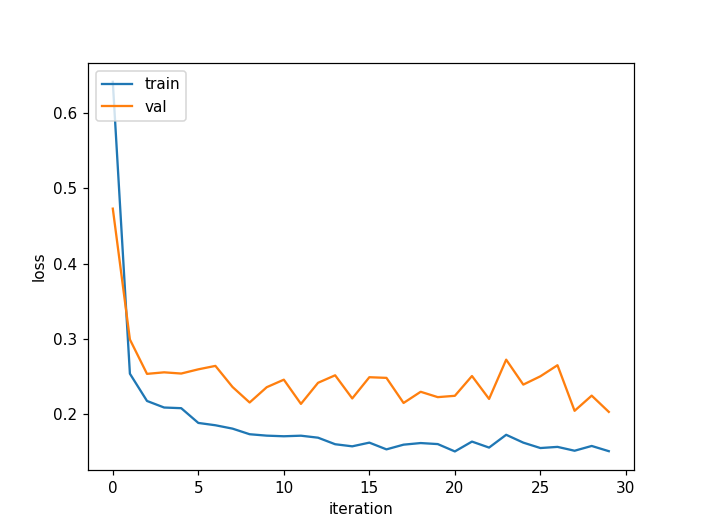

Text(0, 0.5, 'loss')

In [299]:
# Network Loss Plots
from matplotlib import pyplot as plt
fig0, ax0 = plt.subplots()
ax0.plot(trace.history['loss'], '-')
ax0.plot(trace.history['val_loss'], '-')
ax0.legend(['train', 'val'], loc='upper left')
ax0.set_xlabel('iteration')
ax0.set_ylabel('loss')

In [300]:
#look at errors at never-before-seen test data generated from similar objects in ModelNet10
guess = model.predict(x_train[:4])
error = y_train[:4] - guess
# print(guess)
# print(y_train[:4])
# print(error)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [301]:
#Generate special test data for this visualization (evenly sampled)
#  (doing this so we can draw the underlying model from which points were sampled)
fn = 'C:/Users/Derm/Desktop/big/ModelNet10/toilet/train/toilet_0069.off' #0310 looks best
M = trimesh.load(fn)

n_tests = 1 #number of test samples to generate
#init vector to store sampled point clouds
x_test2 = np.zeros([n_tests, ptsPerCloud*2, 3])
#init vector to store transformations 
y_test2 = np.zeros([n_tests, 6]) #rotation and translation

sam1 = trimesh.sample.sample_surface(M, n_tests*ptsPerCloud)[0] #get keyframe scan
sam2 = trimesh.sample.sample_surface(M, n_tests*ptsPerCloud)[0] #get new scan

for j in range(n_tests):
    angs1 = 1.0*tf.random.normal([3])    #rotate keyframe
    rot1 = R_tf(angs1)
    angs2 = rot_scale*tf.random.normal([3])     #rotate scan 2 relative to keyframe
    rot2 = R_tf(angs2)
#     rot_combined = R_tf(angs1 + angs2) #was this
    rot_combined = tf.matmul(R_tf(angs1), R_tf(angs2))
    
    x_test2[j, :ptsPerCloud, :] = sam1[j*ptsPerCloud:(j+1)*ptsPerCloud].dot(rot1.numpy())         

    trans = trans_scale*tf.random.normal([3])
    sam2_j = trans + sam2[j*ptsPerCloud:(j+1)*ptsPerCloud].dot(rot_combined.numpy()) #transform scan
    x_test2[j, ptsPerCloud:, :] = sam2_j

    #save transformation as y
    y_test2[j,:3] = trans.numpy()/trans_scale
    y_test2[j,3:] = angs2.numpy()/rot_scale
print(tf.shape(x_test2))

tf.Tensor([  1 512   3], shape=(3,), dtype=int32)


In [302]:
#visualize network performance on evenly sampled data
t = 0 #test number to draw
niter = 5 #number of iterations to run network for

plt2 = Plotter(N = 3, axes = 4, bg = (1, 1, 1), interactive = True)
disp1 = [] #before estimated transformation (drawn on left)
disp2 = [] #after 1 transformation (drawn in center)
disp3 = [] #after niter transformations

#draw first viz (untransformed set of scans)-------------------
scan1 = Mesh(M).c("red").alpha(0.1)#.rotate(90, axis = (0,0,1))
scan1.applyTransform(rot1.numpy().T)
disp1.append(scan1)
disp1.append(Points(x_test2[0,:ptsPerCloud], c = 'red', r = 5))

scan2 = Mesh(M).c("blue").alpha(0.1)
scan2.applyTransform(rot_combined.numpy().T)
# scan2.pos(y_test2[t,0], y_test2[t,1], y_test2[t,2])
scan2.pos(y_test2[t,0]*trans_scale, y_test2[t,1]*trans_scale, y_test2[t,2]*trans_scale)
disp1.append(scan2)
disp1.append(Points(x_test2[0,ptsPerCloud:], c = 'blue', r = 5))

#FOR DEBUG - draw ground truth transformation in green so I can be sure which order is correct
correct = (x_test2[0,ptsPerCloud:] - y_test2[0,:3]*trans_scale).dot(R_tf(y_test2[0,3:]*rot_scale).numpy().T)
temp = Points(correct, c = 'green', r = 5)
disp1.append(temp)
#---------------------------------------------------------------

#draw esatimated soln after 1 iteration ------------------------
ans_cum = model.predict(x_test2)[t]
ans_cum[:3] = ans_cum[:3]*trans_scale
ans_cum[3:] = ans_cum[3:]*rot_scale

scan2_transformed = Mesh(M).c("blue").alpha(0.1)
soln_est_rot = R_tf(ans_cum[3:])
scan2_transformed.applyTransform(soln_est_rot.numpy().dot(rot_combined.numpy().T)) #test
scan2_transformed.pos(y_test2[t,0]*trans_scale - ans_cum[0], 
                      y_test2[t,1]*trans_scale - ans_cum[1], 
                      y_test2[t,2]*trans_scale - ans_cum[2])
disp2.append(scan2_transformed)


disp2.append(Mesh(M).c("red").alpha(0.1).applyTransform(rot1.numpy().T))

#add points
scan2_pts_transformed = (x_test2[0,ptsPerCloud:] - ans_cum[:3]).dot(soln_est_rot.numpy().T)
disp2.append(Points(x_test2[0,:ptsPerCloud], c = 'red', r = 5))
disp2.append(Points(scan2_pts_transformed, c = 'blue', r = 5))
# disp2.append(Points((x_test2[0,ptsPerCloud:]).dot(soln_est_rot.numpy().T) - ans[:3], c = 'blue', r = 5))
gt = y_test2[t].copy()
gt[:3] = gt[:3]*trans_scale
gt[3:] = gt[3:]*rot_scale
print("\n ground truth:", gt)
print("\n estimate from DNN after 1 iteration:", ans_cum)
#-----------------------------------------------------------------

# draw estiamted soln after n interations-------------------------
for i in range(niter):
    #replace initial scan2 with transformed pc2 as input to network
    inlayer = tf.concat([x_test2[0][:ptsPerCloud], scan2_pts_transformed], axis = 0)[None, :, :]
    ans_i = model.predict(inlayer)[0]
    ans_i[:3] = ans_i[:3]*trans_scale
    ans_i[3:] = ans_i[3:]*rot_scale
    
#     soln_est_rot = R_tf(ans_cum[3:]) #wrong?
    soln_est_rot = tf.matmul(R_tf(ans_i[3:]), soln_est_rot)
#     ans_cum = ans_cum + ans_i
    ans_cum[:3] = ans_cum[:3] + ans_i[:3]
#     ans_cum[3:] = ans_cum[3:].dot(ans_i[3:]) #wrong
    ans_cum[3:] = R2Euler(soln_est_rot)[:,0]
#     print(R2Euler(soln_est_rot))
    scan2_pts_transformed = (x_test2[0,ptsPerCloud:] - ans_cum[:3]).dot(soln_est_rot.numpy().T)
    
print("\n estimate from DNN after", niter, "iterations: ", ans_cum) 

disp3.append(Mesh(M).c("red").alpha(0.1).applyTransform(rot1.numpy().T))
scan2_transformed_again = Mesh(M).c("blue").alpha(0.1)
scan2_transformed_again.applyTransform(soln_est_rot.numpy().dot(rot_combined.numpy().T)) #test
scan2_transformed_again.pos(y_test2[t,0]*trans_scale - ans_cum[0], 
                            y_test2[t,1]*trans_scale - ans_cum[1], 
                            y_test2[t,2]*trans_scale - ans_cum[2])
disp3.append(scan2_transformed_again)
disp3.append(Points(scan2_pts_transformed, c = 'blue', r = 5))
disp3.append(Points(x_test2[0,:ptsPerCloud], c = 'red', r = 5))

print("------- \n Final Error:", gt - ans_cum)
# #---------------------------------------------------------------

    
plt2.show(disp1, "initial transformation", at = 0)
plt2.show(disp2, "after 1 iteration", at = 1)
plt2.show(disp3, "after 5 iterations", at = 2)
ViewInteractiveWidget(plt2.window)


 ground truth: [-21.53272867   8.40733886   6.40020847   0.07301893   0.15843208
   0.0730213 ]

 estimate from DNN after 1 iteration: [-1.2840777e+01  4.3590822e+00  2.3933051e+00  2.7102516e-03
 -4.5583546e-03 -4.9842796e-03]

 estimate from DNN after 5 iterations:  [-2.5662579e+01  8.3535929e+00  4.0044751e+00 -5.6819664e-03
  1.4071466e-02  3.4658078e-02]
------- 
 Final Error: [4.12984991 0.05374599 2.39573336 0.0787009  0.14436061 0.03836323]


ViewInteractiveWidget(height=568, layout=Layout(height='auto', width='100%'), width=1706)

In [223]:
# model.save("DermNet_ModelNet_benchmark.kmod") #256 pts per cloud, MAE =~ 0.31

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: DermNet_ModelNet_benchmark.kmod\assets


In [182]:
#Can't just add euler angles in 3D...
a = tf.constant([[1., 2., 3.]])
A = R_tf(a)
b = tf.constant([[0.3, 0.2, 0.1]])
B = R_tf(b)
print(tf.matmul(A, B))
print(R_tf(a + b))


tf.Tensor(
[[ 0.5886282  -0.75547487  0.28770593]
 [-0.03155808 -0.3770966  -0.9256362 ]
 [ 0.8077877   0.5357761  -0.24581096]], shape=(3, 3), dtype=float32)
tf.Tensor(
[[ 0.5879922  -0.76723665  0.2561503 ]
 [ 0.02447033 -0.29966033 -0.9537321 ]
 [ 0.80849636  0.5670551  -0.1574234 ]], shape=(3, 3), dtype=float32)


In [183]:
print(A.numpy().T)
print(np.linalg.pinv(A.numpy()))

[[ 0.41198224  0.05872664  0.9092974 ]
 [-0.6812427  -0.6428728   0.35017547]
 [ 0.6051272  -0.76371837 -0.22484507]]
[[ 0.41198224  0.05872662  0.9092975 ]
 [-0.6812428  -0.6428728   0.35017556]
 [ 0.6051273  -0.7637183  -0.22484513]]


In [216]:
tf.matmul(R_tf(tf.constant([0.,0.,0.])), R_tf(a))

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[ 0.41198224, -0.6812427 ,  0.6051272 ],
       [ 0.05872664, -0.6428728 , -0.76371837],
       [ 0.9092974 ,  0.35017547, -0.22484507]], dtype=float32)>